In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import time

import numpy as np

import torch
import torch.nn.functional as F

import cv2

import matplotlib
import matplotlib.pyplot as plt

from viz_svls import LS, SVLS
from datasets import get_datasets_brats

In [2]:
DATA_PATH = '/home/s2018013343/project/exp4_dl/SVLS/MICCAI_BraTS_2019_Data_Training/HGG_LGG'

train_dataset, val_dataset = get_datasets_brats(data_root=DATA_PATH)

In [3]:
ls = LS(4, 0.1).cuda()
svls = SVLS(4, 1.0).cuda()

选取样本

In [4]:
sample_idx = 80

item = train_dataset[sample_idx]
label = item['label'].cuda()
image = item['image'].float().cuda()

label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))
label_ls = ls(label)
label_svls = svls(label)

label_oh_ = label_oh.cpu().numpy()
label_ls_ = label_ls.cpu().numpy()
label_svls_ = label_svls.cpu().numpy()

print(label_oh_.shape)
print(label_ls_.shape)
print(label_svls_.shape)

(1, 4, 128, 192, 192)
(1, 4, 128, 192, 192)
(1, 4, 128, 192, 192)


可视化样本

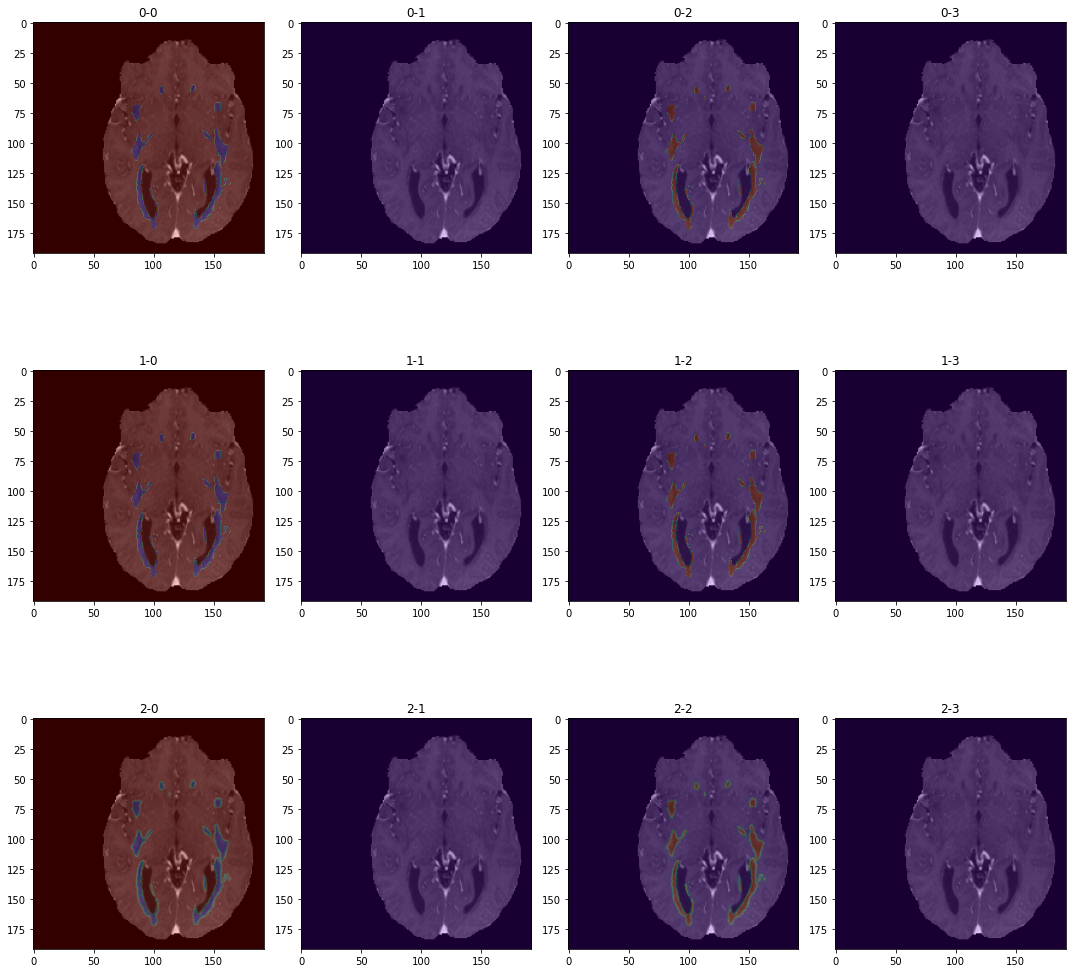

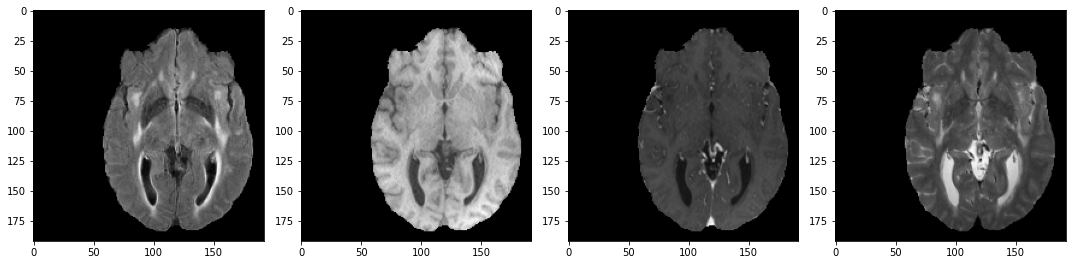

In [5]:
depth = 50

label_slice_oh = label_oh[0, :, depth, ...].cpu().numpy()
label_slice_ls = label_ls[0, :, depth, ...].cpu().numpy()
label_slice_svls = label_svls[0, :, depth, ...].cpu().numpy()


image_slice = image[:, depth, ...].cpu().numpy()


figure, axs = plt.subplots(3, 4, figsize=(15, 15))

_slices = [label_slice_oh, label_slice_ls, label_slice_svls]

for _type in range(3):
    _slice = _slices[_type]
    for _class in range(4):
        # print(f'{_type}-{_class}')
        # print(np.unique(_slice[_class+1]))
        axs[_type, _class].imshow(_slice[_class], cmap='rainbow')
        axs[_type, _class].imshow(image_slice[2], alpha=0.8, cmap='gray')
        axs[_type, _class].set_title(f'{_type}-{_class}')
plt.tight_layout()
plt.show()

figure, axs = plt.subplots(1, 4, figsize=(15, 15))
for seq in range(4):
    axs[seq].imshow(image_slice[seq], cmap='gray')
plt.tight_layout()
plt.show()

In [9]:
from svls import CELossWithSVLS, CELossWithSVLS_V3

svls = CELossWithSVLS(classes=4).cuda()
svls_v3 = CELossWithSVLS_V3(classes=4, sigma=1, scale_factor=2.2).cuda()

In [10]:
dummy = torch.rand((1, 4, 128, 192, 192)).float().cuda()

output_svls = svls(dummy, label)

output_svls_v3 = svls_v3(dummy, label)

print(output_svls)

print(output_svls_v3)

print(output_svls_v3 - output_svls)

/home/s2018013343/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor([[[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000

/home/s2018013343/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


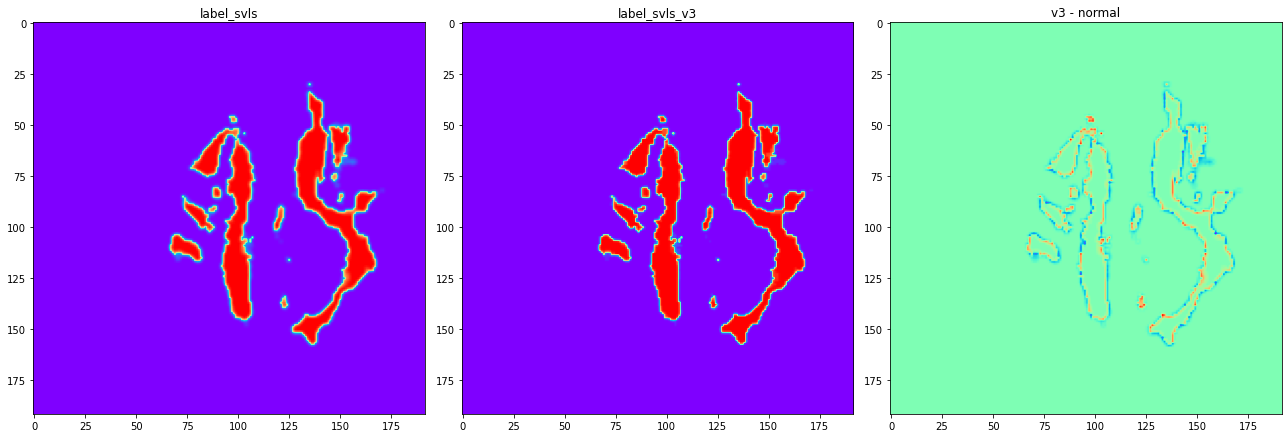

In [11]:
label_svls_v3_np = output_svls_v3.cpu().numpy()
label_svls_np = output_svls.cpu().numpy()
diff = label_svls_v3_np - label_svls_np

depth = 77

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
ax1, ax2, ax3 = axs.ravel()

ax1.imshow(label_svls_np[0, 2, depth], cmap='rainbow')
ax1.set_title('label_svls')
ax2.imshow(label_svls_v3_np[0, 2, depth], cmap='rainbow')
ax2.set_title('label_svls_v3')
ax3_ = ax3.imshow(diff[0, 2, depth], cmap='rainbow')
ax3.set_title("v3 - normal")
# plt.colorbar(ax3_, ax=ax3)

plt.tight_layout()
plt.show()

In [14]:
from svls import get_svls_filter_3d


class CELossWithSVLS_V3(torch.nn.Module):
    def __init__(self, classes=None, sigma=1, scale_factor=1.0):
        super(CELossWithSVLS_V3, self).__init__()
        self.cls = torch.tensor(classes)
        self.cls_idx = torch.arange(self.cls).reshape(1, self.cls).cuda()
        self.svls_layer, self.svls_kernel = get_svls_filter_3d(sigma=sigma, channels=classes)
        self.svls_kernel = self.svls_kernel.cuda()
        self.scale_factor = scale_factor

    def forward(self, inputs, labels):
        with torch.no_grad():
            n, z, x, y = labels.shape

            aff = torch.FloatTensor([[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]]).expand(n, 3, 4)
            grid_up = F.affine_grid(aff, size=(n, 1, int(self.scale_factor * z),
                                                     int(self.scale_factor * x),
                                                     int(self.scale_factor * y))).cuda()
            grid_down = F.affine_grid(aff, size=(n, 1, z, x, y)).cuda()

            # up sample
            labels_up_sample = F.grid_sample(labels[:, None, ...].float(), grid_up, mode='nearest').squeeze(dim=1)

            # get svls label
            oh_labels = (labels_up_sample[...,None] == self.cls_idx).permute(0,4,1,2,3)
            b, c, d, h, w = oh_labels.shape
            x = oh_labels.view(b, c, d, h, w).repeat(1, 1, 1, 1, 1).float()
            x = F.pad(x, (1,1,1,1,1,1), mode='replicate')
            svls_labels = self.svls_layer(x)/self.svls_kernel.sum()

            # down sample
            svls_labels = F.grid_sample(svls_labels.float(), grid_down, mode='bilinear')
            return svls_labels
        # return (- svls_labels * F.log_softmax(inputs, dim=1)).sum(dim=1).mean()

class CELossWithSVLS_V3_NEW(torch.nn.Module):
    def __init__(self, classes=None, sigma=1, scale_factor=1.0):
        super(CELossWithSVLS_V3_NEW, self).__init__()
        self.cls = torch.tensor(classes)
        self.cls_idx = torch.arange(self.cls).reshape(1, self.cls).cuda()
        self.svls_layer, self.svls_kernel = get_svls_filter_3d(sigma=sigma, channels=classes)
        self.svls_kernel = self.svls_kernel.cuda()
        self.scale_factor = scale_factor
        self.aff = torch.FloatTensor([[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]])

    def forward(self, inputs, labels):
        with torch.no_grad():
            n, z, x, y = labels.shape

            aff = self.aff.expand(n, 3, 4)

            # up sample
            grid_up = F.affine_grid(aff, size=(n, 1, int(self.scale_factor * z),
                                                     int(self.scale_factor * x),
                                                     int(self.scale_factor * y))).cuda()
            labels = F.grid_sample(labels[:, None, ...].float(), grid_up, mode='nearest').squeeze(dim=1)
            del grid_up

            # get svls label
            labels = (labels[...,None] == self.cls_idx).permute(0,4,1,2,3)
            b, c, d, h, w = labels.shape
            labels = labels.view(b, c, d, h, w).repeat(1, 1, 1, 1, 1).float()
            labels = F.pad(labels, (1,1,1,1,1,1), mode='replicate')
            labels = self.svls_layer(labels)/self.svls_kernel.sum()

            # down sample
            grid_down = F.affine_grid(aff, size=(n, 1, z, x, y)).cuda()
            labels = F.grid_sample(labels.float(), grid_down, mode='bilinear')
            del grid_down
        return labels
        # return (- labels * F.log_softmax(inputs, dim=1)).sum(dim=1).mean()


svls_v3 = CELossWithSVLS_V3(classes=4, sigma=1, scale_factor=1.4).cuda()
svls_v3_new = CELossWithSVLS_V3_NEW(classes=4, sigma=1, scale_factor=1.4).cuda()

dummy = torch.rand((1, 4, 128, 192, 192)).float().cuda()

output_svls_v3 = svls_v3(dummy, label)
output_svls_v3_new = svls_v3_new(dummy, label)

print(torch.max(output_svls_v3 - output_svls_v3_new))